In [3]:
########################## ETL para Análise de Séries Temporais do Walmart ###############################

import pandas as pd
import duckdb

# Carregar os dados
train_df = pd.read_csv('/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/data/train.csv')
features_df = pd.read_csv('/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/data/features.csv')
stores_df = pd.read_csv('/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/data/stores.csv')

# Exemplo de como usar SQL para juntar os dados
query = """
SELECT
    tr.Store,
    st.Type,
    st.Size,
    tr.Dept,
    tr.Date,
    tr.Weekly_Sales,
    tr.IsHoliday,
    ft.Temperature,
    ft.Fuel_Price,
    ft.CPI,
    ft.Unemployment
FROM train_df tr
LEFT JOIN stores_df st ON tr.Store = st.Store
LEFT JOIN features_df ft ON tr.Store = ft.Store AND tr.Date = ft.Date
"""
df_full = duckdb.query(query).to_df()

# Converter a coluna de data
df_full['Date'] = pd.to_datetime(df_full['Date'])

# Lidar com valores nulos (ex: preencher com a mediana)
# Em PySpark: df.fillna({'CPI': media_cpi})
df_full['CPI'] = df_full['CPI'].fillna(df_full['CPI'].median())
df_full['Unemployment'] = df_full['Unemployment'].fillna(df_full['Unemployment'].median())

df_store1 = df_full[df_full['Store'] == 1].copy()

df_model_data = df_store1.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'IsHoliday': lambda x: any(x) 
}).reset_index()

df_model_data.sort_values('Date', inplace=True)

print("Dados da Loja 1 prontos para Feature Engineering:")
print(df_model_data.head())

# Agrupar dados para ter uma única série temporal (vendas totais do Walmart)
df_total_sales = df_full.groupby('Date')['Weekly_Sales'].sum().reset_index()
df_total_sales = df_total_sales.set_index('Date')
df_total_sales.sort_index(inplace=True)


Dados da Loja 1 prontos para Feature Engineering:
        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  Unemployment  \
0 2010-02-05    1643690.90        42.31       2.572  211.096358         8.106   
1 2010-02-12    1641957.44        38.51       2.548  211.242170         8.106   
2 2010-02-19    1611968.17        39.93       2.514  211.289143         8.106   
3 2010-02-26    1409727.59        46.63       2.561  211.319643         8.106   
4 2010-03-05    1554806.68        46.50       2.625  211.350143         8.106   

   IsHoliday  
0      False  
1       True  
2      False  
3      False  
4      False  


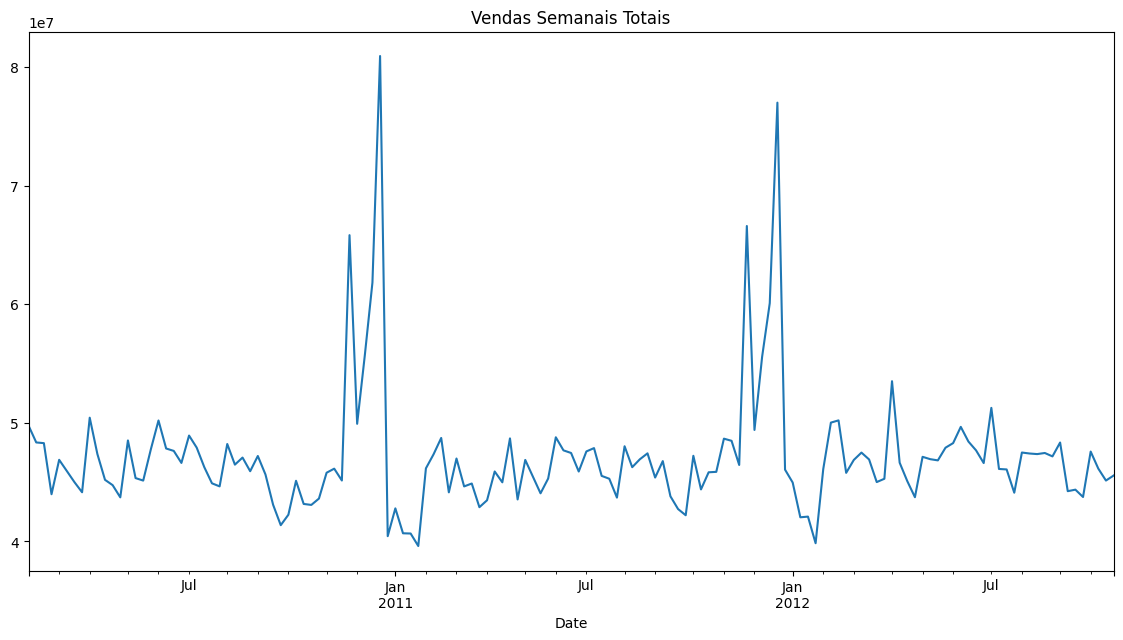

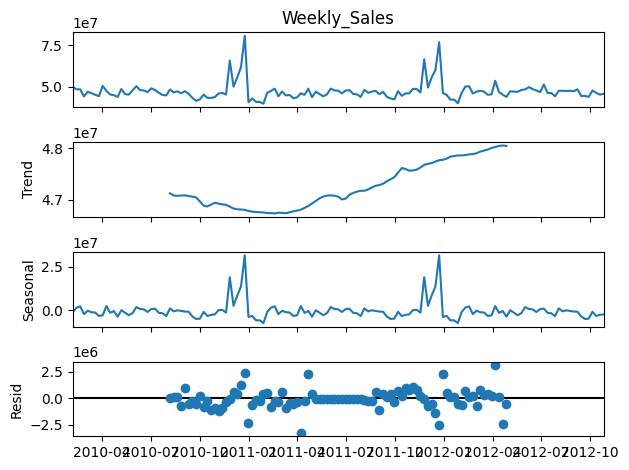

ADF Statistic: -5.908297957186334
p-value: 2.675979158986027e-07


In [4]:
########################## Análise Exmplotatória de Dados (EDA) de Séries Temporais ###############################

# Ação: Analisar a série de vendas totais (df_total_sales)
# Objetivos: Verificar estacionaridade, sazonalidade, tendência e outliers

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# 1. Visualizar a série
df_total_sales['Weekly_Sales'].plot(figsize=(14, 7), title='Vendas Semanais Totais')
plt.show()

# 2. Decomposição (tendência, sazonalidade, resíduos)
# Frequência semanal -> sazonalidade anual de 52 semanas
decomposition = seasonal_decompose(df_total_sales['Weekly_Sales'], model='additive', period=52)
decomposition.plot()
plt.show()

# 3. Teste de Estacionariedade (ADF)
result = adfuller(df_total_sales['Weekly_Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}') # Se p-value > 0.05, a série não é estacionária


In [5]:
######################## Feature Engineering ################################
# Ação: Criar novas varáveis (features) a partir dos dados existentes para usar nos modelos de Machine Learning
# Objetivos: Capturar informações temporais que o modelo possa usar

df_model_data['year'] = df_model_data['Date'].dt.year
df_model_data['month'] = df_model_data['Date'].dt.month
df_model_data['week_of_year'] = df_model_data['Date'].dt.isocalendar().week

df_model_data['sales_lag_1'] = df_model_data['Weekly_Sales'].shift(1)
df_model_data['sales_lag_4'] = df_model_data['Weekly_Sales'].shift(4) # Lag de 1 mês
df_model_data['sales_lag_52'] = df_model_data['Weekly_Sales'].shift(52) # Lag de 1 ano

df_model_data['sales_rolling_mean_4'] = df_model_data['Weekly_Sales'].shift(1).rolling(window=4).mean()

# MUITO IMPORTANTE: Agora, vamos preencher os NaNs em vez de dropá-los
# para não perder o começo da série. Podemos usar o método 'backfill'.
df_model_data.fillna(method='bfill', inplace=True)

print("Engenharia de Features Concluída, sem perda de dados.")
df_model_data.head()

Engenharia de Features Concluída, sem perda de dados.


/tmp/ipykernel_199958/2483241424.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model_data.fillna(method='bfill', inplace=True)


,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,year,month,week_of_year,sales_lag_1,sales_lag_4,sales_lag_52,sales_rolling_mean_4
0,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False,2010,2,5,1643690.90,1643690.9,1643690.9,1576836.025
1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True,2010,2,6,1643690.90,1643690.9,1643690.9,1576836.025
2,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False,2010,2,7,1641957.44,1643690.9,1643690.9,1576836.025
3,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False,2010,2,8,1611968.17,1643690.9,1643690.9,1576836.025
4,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False,2010,3,9,1409727.59,1643690.9,1643690.9,1576836.025


In [7]:
# Exportando o DataFrame de uma loja como CSV
df_model_data.to_csv('/home/davi/pyproject/portifolio/projeto_series_temporais/projeto_series_temporais/data/loja_1_model_data.csv', index=False)

In [8]:
############################# Modelagem Preditiva (Forecasting) ################################
# Ação: Treinar modelos de previsão de séries temporais
# Objetivos: Utilizar abordagens clássicas e de Machine Learning para prever vendas futuras

## Divisão de Dados (Time-Based Split)

# Importante: para séries temporais, NUNCA embaralhe os dados!
train_size = int(len(df_model_data) * 0.8)
train, test = df_model_data[0:train_size], df_model_data[train_size:len(df_model_data)]

X_train = train.drop(['Weekly_Sales', 'Date'], axis=1)
y_train = train['Weekly_Sales']
X_test = test.drop(['Weekly_Sales', 'Date'], axis=1)
y_test = test['Weekly_Sales']

In [10]:
# Modelo de Machine Learning

import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error

# Treinar o modelo
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

# Fazer a previsão
predictions_lgbm = lgbm.predict(X_test)
mape_lgbm = mean_absolute_percentage_error(y_test, predictions_lgbm)
print(f"MAPE do LightGBM: {mape_lgbm:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 11
[LightGBM] [Info] Start training from score 1551089.387061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

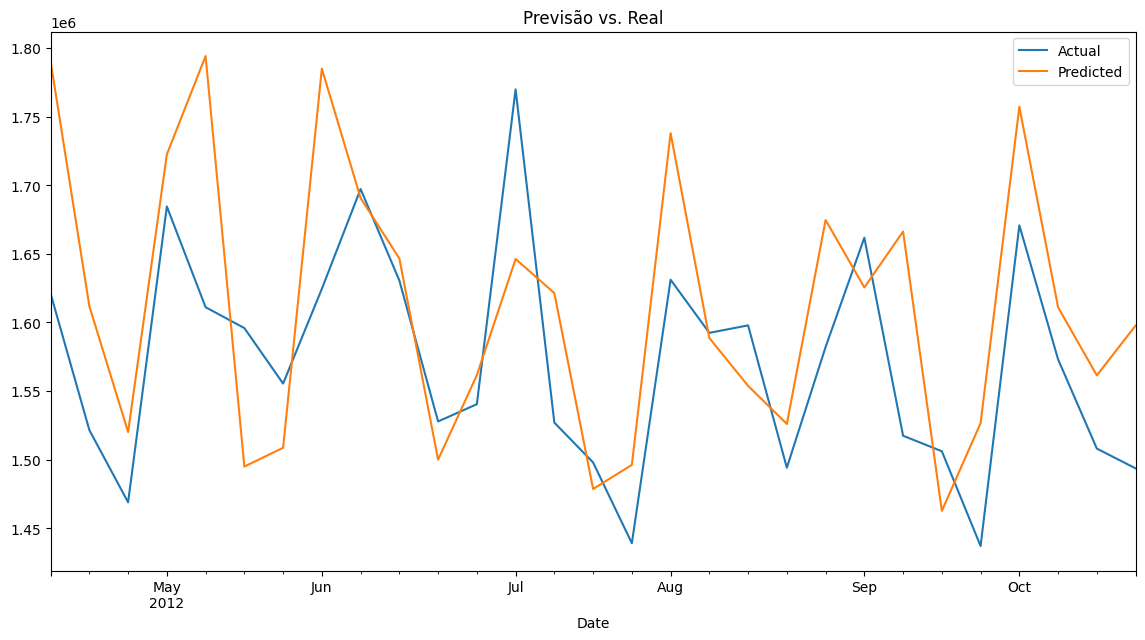

In [11]:
# Criar um dataframe de resultados para visualização
results_df = pd.DataFrame({'Date': test['Date'], 'Actual': y_test, 'Predicted': predictions_lgbm})
results_df.set_index('Date', inplace=True)

# Plotar os resultados
results_df.plot(figsize=(14, 7), title='Previsão vs. Real')
plt.show()